<a href="https://colab.research.google.com/github/lastinm/ml_hw_notebooks/blob/main/%D0%A3%D1%80%D0%A4%D0%A3_%D0%9C%D0%9E%D0%9C%D0%9E_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%E2%84%962.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование продаж магазина на основе временных рядов

# Импорт необходимых библиотек

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates#Date Parser

import seaborn as sns
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

# Установка фиксированного значения
np.random.seed(42)

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
#warnings.simplefilter('ignore', ConvergenceWarning)

# Загрузка датасета и подготовка данных

Основной датасет представляет собой продажи различных категорий товаров в одном из магазинов. Состав полей в файле train.csv:

* store_nbr — идентификатор магазина;
* family — категория товаров;
* sales — общий объем продаж для категории товаров в магазине на заданную дату (возможно указание дробных значений);
* onpromotion — количество товаров, участвующих в акциях на определенную дату.

Загрузим датасет. Сразу преобразуем к типу DateTime содержимое поля 'date' и проиндексируем датафрейм по этому полю. Так же исключим из загрузки поле 'id'.

In [4]:
url='https://drive.google.com/file/d/1Q5gkD3X5VUdYPtvznm4Zj115VD_A5Anx/view?usp=sharing'
DF = pd.read_csv('https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(url.split('/')[-2]),
            sep=',',
            index_col='date',
            parse_dates=True,
            usecols=lambda column: column != 'id',
            low_memory=False)
print(DF.head(5))
print("="*80)
print(DF.info())

            store_nbr      family  sales  onpromotion
date                                                 
2013-01-01          1  AUTOMOTIVE    0.0            0
2013-01-01          1   BABY CARE    0.0            0
2013-01-01          1      BEAUTY    0.0            0
2013-01-01          1   BEVERAGES    0.0            0
2013-01-01          1       BOOKS    0.0            0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 114.5+ MB
None


Выбрем один магазин и пять категорий товаров.

In [5]:
store_nbr = 1  # например, магазин 1
categories = ['MEATS', 'CELEBRATION', 'CLEANING', 'SEAFOOD', 'LAWN AND GARDEN']  # выбранные категории

# Фильтруем DataFrame
df_filtered = DF[(DF['store_nbr'] == store_nbr) & (DF['family'].isin(categories))]

# Проверяем результат
print(df_filtered.head())
print("="*80)
print(df_filtered.info())

            store_nbr           family  sales  onpromotion
date                                                      
2013-01-01          1      CELEBRATION    0.0            0
2013-01-01          1         CLEANING    0.0            0
2013-01-01          1  LAWN AND GARDEN    0.0            0
2013-01-01          1            MEATS    0.0            0
2013-01-01          1          SEAFOOD    0.0            0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8420 entries, 2013-01-01 to 2017-08-15
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    8420 non-null   int64  
 1   family       8420 non-null   object 
 2   sales        8420 non-null   float64
 3   onpromotion  8420 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 328.9+ KB
None


Удалим пропуски и дубликаты данных.

In [6]:
df_filtered.isna().sum()

,0
store_nbr,0
family,0
sales,0
onpromotion,0


In [7]:
# Сначала удалим строки с пропущенными значениями
#df_cleaned = df_filtered.dropna()

# Уберем дни с нулевыми продажами
#df_cleaned = df_cleaned[df_cleaned['sales'] != 0]
df_cleaned = df_filtered.copy()
df_cleaned['sales'] = df_cleaned['sales'].replace(0, 0.00001)

# Затем удалим дубликаты
#df_cleaned = df_cleaned.drop_duplicates()

# Проверяем результаты
print("Размер оригинального DataFrame:", df_filtered.shape)
print("Размер очищенного DataFrame:", df_cleaned.shape)
df_cleaned

Размер оригинального DataFrame: (8420, 4)
Размер очищенного DataFrame: (8420, 4)


,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,CELEBRATION,0.00001,0
2013-01-01,1,CLEANING,0.00001,0
2013-01-01,1,LAWN AND GARDEN,0.00001,0
2013-01-01,1,MEATS,0.00001,0
2013-01-01,1,SEAFOOD,0.00001,0
...,...,...,...,...
2017-08-15,1,CELEBRATION,21.00000,0
2017-08-15,1,CLEANING,703.00000,10
2017-08-15,1,LAWN AND GARDEN,17.00000,0


## Удаление выбросов

Удаление выбросов из данных может быть выполнено разными способами, в зависимости от данных и целей. Несколько распространенных методов для идентификации и удаления выбросов:

1. Использование метода межквартильного размаха (IQR)

Этот метод широко используется для определения выбросов. Выбросы - это значения, которые находятся ниже первого квартиля минус 1.5 * IQR или выше третьего квартиля плюс 1.5 * IQR.
2.  Использование стандартного отклонения

Другой распространённый метод заключается в использовании стандартного отклонения. Выбросы определяются как значения, которые находятся за пределами определенного числа стандартных отклонений от среднего.

3. Метод Z-оценки

Z-оценка показывает, насколько далеко значение находится от среднего в стандартных отклонениях. Значения Z-оценки больше 3 или меньше -3 могут считаться выбросами.

Выбор метода удаления выбросов зависит от данных и специфики задачи. Методы IQR и Z-оценки подходят для нормальных распределений, тогда как стандартное отклонение может применяться для значений, которые могут не следовать нормальному распределению. Проведем предварительный анализ данных, чтобы выбрать наиболее подходящий метод.

Теперь мы можем визуализировать данные по продажам для каждой категории товаров.

In [8]:
def draw_graph(df, category):
  plt.figure(figsize=(12, 6))
  plt.plot(df.index, df['sales'], label=category)
  plt.title(f'Продажи по категории: {category}')
  plt.xlabel('Дата')
  plt.ylabel('Общие продажи')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show()

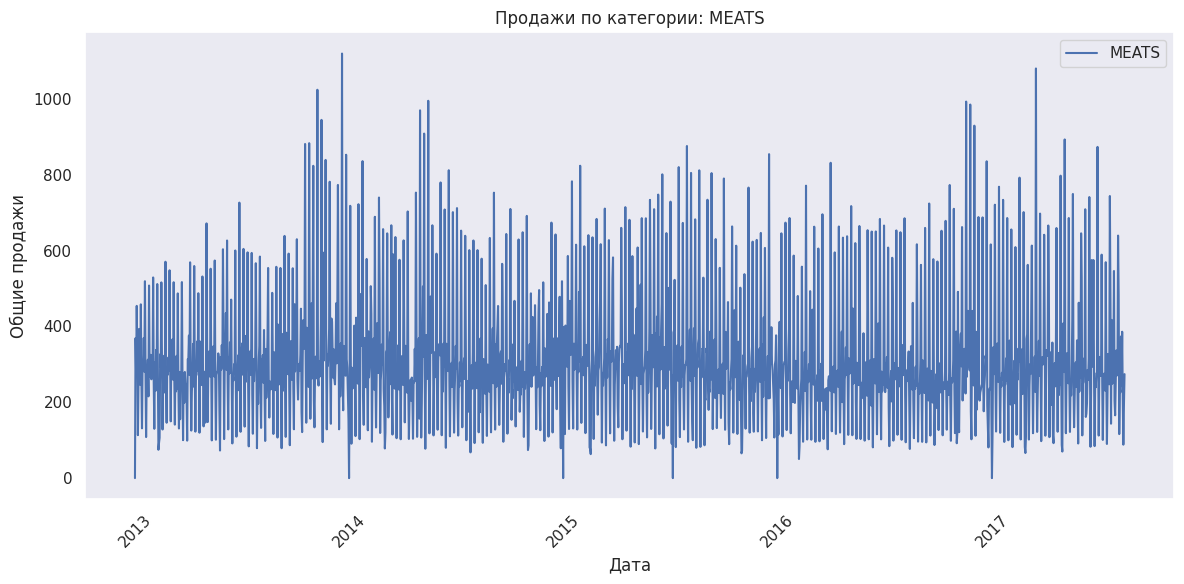

In [9]:
# Выберем данные для категорий: 'MEATS', 'CELEBRATION', 'CLEANING', 'SEAFOOD', 'LAWN AND GARDEN'
category = 'MEATS'  # выбранные категории

# Фильтруем DataFrame
df_SEAFOOD = df_cleaned[df_cleaned['family'] == category]
draw_graph(df_SEAFOOD, category)

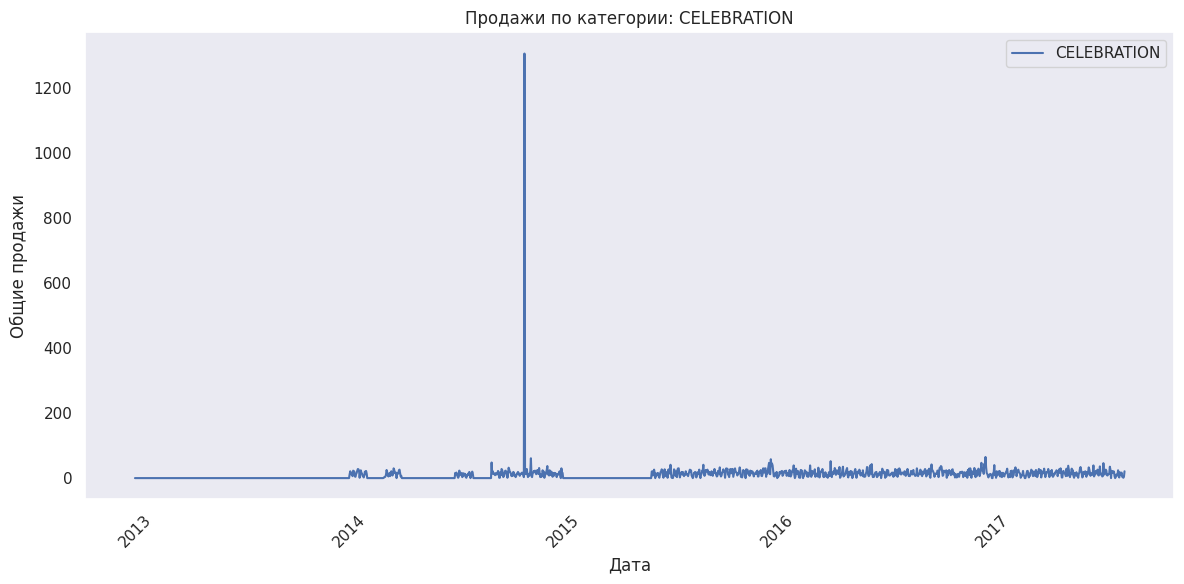

In [10]:
# Выберем данные для категорий: 'MEATS', 'CELEBRATION', 'CLEANING', 'SEAFOOD', 'LAWN AND GARDEN'
category = 'CELEBRATION'  # выбранные категории

# Фильтруем DataFrame
df_SEAFOOD = df_cleaned[df_cleaned['family'] == category]
draw_graph(df_SEAFOOD, category)

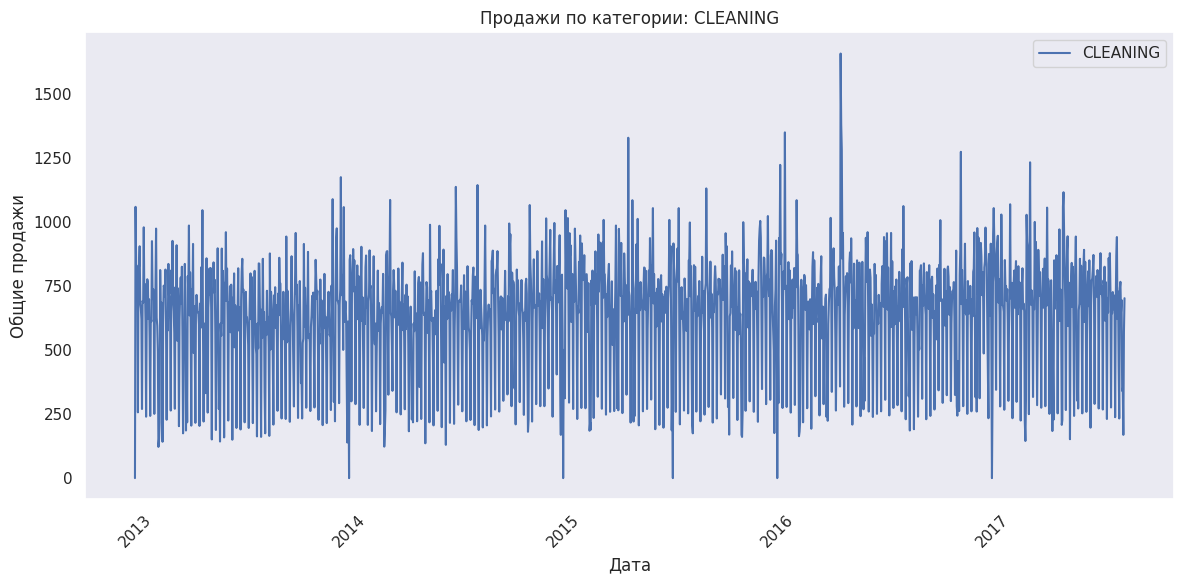

In [11]:
# Выберем данные для категорий: 'MEATS', 'CELEBRATION', 'CLEANING', 'SEAFOOD', 'LAWN AND GARDEN'
category = 'CLEANING'  # выбранные категории

# Фильтруем DataFrame
df_SEAFOOD = df_cleaned[df_cleaned['family'] == category]
draw_graph(df_SEAFOOD, category)

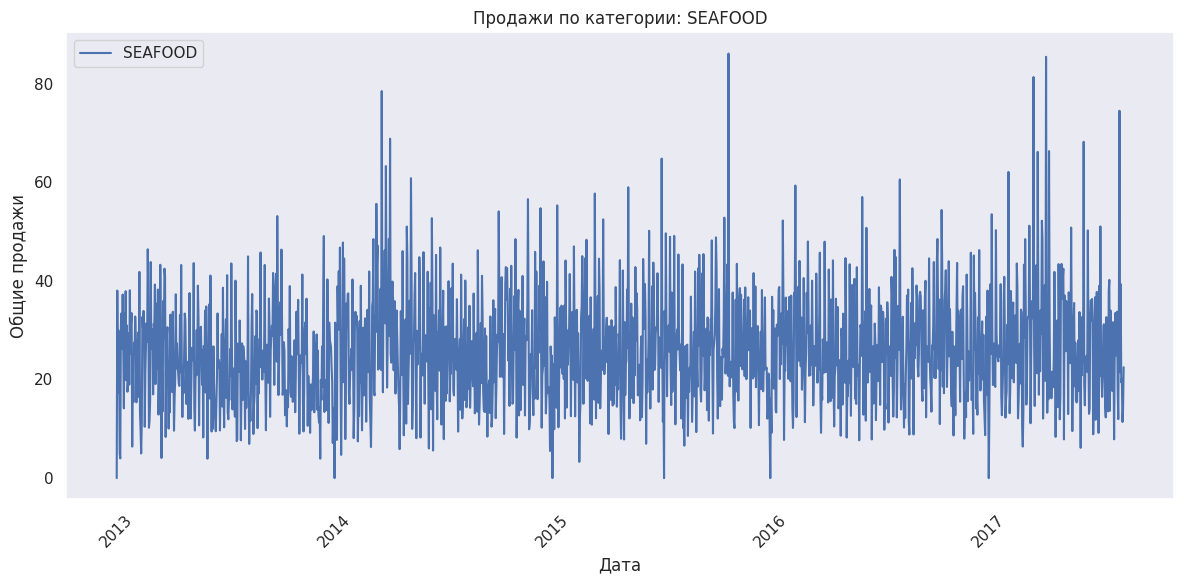

In [12]:
# Выберем данные для категорий: 'MEATS', 'CELEBRATION', 'CLEANING', 'SEAFOOD', 'LAWN AND GARDEN'
category = 'SEAFOOD'  # выбранные категории

# Фильтруем DataFrame
df_SEAFOOD = df_cleaned[df_cleaned['family'] == category]
draw_graph(df_SEAFOOD, category)

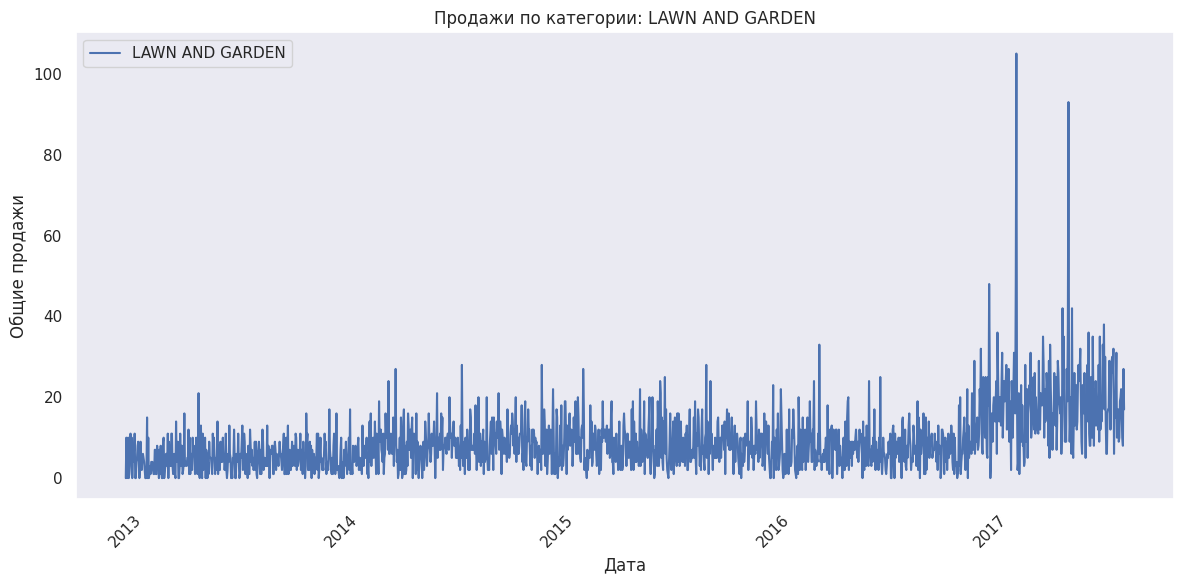

In [13]:
# Выберем данные для категорий: 'MEATS', 'CELEBRATION', 'CLEANING', 'SEAFOOD', 'LAWN AND GARDEN'
category = 'LAWN AND GARDEN'  # выбранные категории

# Фильтруем DataFrame
df_SEAFOOD = df_cleaned[df_cleaned['family'] == category]
draw_graph(df_SEAFOOD, category)

На полученных графиках мы видим близкое к нормальному распределению для двух категорий - MEATS, CLEANING и SEAFOOD. Для удаления выбросов применим к ним метод Z-оценки. Остальные категории почистим методом исследования стандартного отклонения.

In [14]:
def remove_outliers_zscore(df, column, threshold=3):
    # Вычисляем Z-оценки
    z_scores = np.abs(stats.zscore(df[column]))

    # Вычисляем среднее значение по указанному столбцу
    mean_value = df[column].mean()

    # Заменяем значения, выходящие за пределы порога Z-оценки, на среднее
    df.loc[z_scores > threshold, column] = mean_value

    return df

In [15]:
# Получаем статистику для каждой группы
stats_summary = df_cleaned.groupby('family')['sales'].describe()

print(stats_summary)

                  count        mean         std      min        25%  \
family                                                                
CELEBRATION      1684.0    9.967938   33.235437  0.00001    0.00001   
CLEANING         1684.0  640.454276  218.090718  0.00001  569.75000   
LAWN AND GARDEN  1684.0    9.007720    7.560526  0.00001    4.00000   
MEATS            1684.0  313.306585  166.167917  0.00001  234.18100   
SEAFOOD          1684.0   25.943592   11.037225  0.00001   18.00400   

                        50%        75%       max  
family                                            
CELEBRATION        6.000000   16.00000  1306.000  
CLEANING         677.000000  774.00000  1659.000  
LAWN AND GARDEN    8.000000   12.00000   105.000  
MEATS            279.859500  347.05275  1119.635  
SEAFOOD           25.169001   32.58675    86.106  


In [16]:
# Выберем данные категории MEATS
categories = ['MEATS']  # выбранные категории

# Фильтруем DataFrame
df_norm = df_cleaned[df_cleaned['family'].isin(categories)]

# Удаляем выбросы в столбце 'sales' с использованием Z-оценки
df_MEATS = remove_outliers_zscore(df_norm, 'sales')

In [17]:
# Выберем данные категории SEAFOOD
categories = ['SEAFOOD']  # выбранные категории

# Фильтруем DataFrame
df_norm = df_cleaned[df_cleaned['family'].isin(categories)]

# Удаляем выбросы в столбце 'sales' с использованием Z-оценки
df_SEAFOOD = remove_outliers_zscore(df_norm, 'sales')

In [18]:
# Выберем данные категории CLEANING
categories = ['CLEANING']  # выбранные категории

# Фильтруем DataFrame
df_norm = df_cleaned[df_cleaned['family'].isin(categories)]

# Удаляем выбросы в столбце 'sales' с использованием Z-оценки
df_CLEANING = remove_outliers_zscore(df_norm, 'sales')

In [19]:
union_df = pd.concat([df_SEAFOOD, df_CLEANING, df_MEATS])

In [20]:
# Получаем статистику для каждой группы
stats_summary = union_df.groupby('family')['sales'].describe()

print(stats_summary)

           count        mean         std      min      25%         50%  \
family                                                                   
CLEANING  1684.0  638.577682  214.556250  0.00001  569.750  676.000000   
MEATS     1684.0  304.190644  148.435541  0.00001  234.181  279.859500   
SEAFOOD   1684.0   25.553342   10.191342  0.00001   18.004   25.169001   

                75%       max  
family                         
CLEANING  773.25000  1284.000  
MEATS     340.25425   804.787  
SEAFOOD    32.38300    58.986  


Категории CELEBRATION, LAWN AND GARDEN почистим от выбросов методом исследования стандартного отклонения.

In [21]:
def remove_outliers_std(df, column, std_threshold=2):
    # Вычисляем среднее и стандартное отклонение
    mean_value = df[column].mean()
    std_value = df[column].std()

    # Определяем верхнюю и нижнюю границы для выбросов
    upper_limit = mean_value + std_threshold * std_value
    lower_limit = mean_value - std_threshold * std_value

    # Заменяем выбросы на среднее значение
    df.loc[(df[column] > upper_limit) | (df[column] < lower_limit), column] = mean_value

    # Заменяем нулевые значения на среднее значение
    #df.loc[df[column] == 0, column] = mean_value

    return df

In [22]:
# Выберем данные категории
categories = ['CELEBRATION']  # выбранные категории

# Фильтруем DataFrame
df_norm = df_cleaned[df_cleaned['family'].isin(categories)]

# Удаляем выбросы в столбце 'sales' с использованием стандартного отклонения
df_CELEBRATION = remove_outliers_std(df_norm, 'sales')

# Проверяем результаты
stats_summary = df_CELEBRATION.groupby('family')['sales'].describe()

print(stats_summary)
# Было:
#                  count        mean         std   min      25%         50%       75%        max
#CELEBRATION      1684.0    9.972001   33.234218  0.01    0.010    6.000000   16.00000  1306.000
#Стало после очистки от выбросов:

              count      mean        std      min      25%  50%   75%   max
family                                                                     
CELEBRATION  1684.0  9.198322  10.293829  0.00001  0.00001  6.0  16.0  65.0


In [23]:
# Выберем данные категории
categories = ['LAWN AND GARDEN']  # выбранные категории

# Фильтруем DataFrame
df_norm = df_cleaned[df_cleaned['family'].isin(categories)]

# Удаляем выбросы в столбце 'sales' с использованием стандартного отклонения
df_LAWN_AND_GARDEN = remove_outliers_std(df_norm, 'sales')

# Проверяем результаты
#print(df_BEAUTY.describe())
stats_summary = df_LAWN_AND_GARDEN.groupby('family')['sales'].describe()

print(stats_summary)
# Было:
#                  count        mean         std  min         25%       50%       75%       max
#LAWN AND GARDEN  1684.0    9.008118    7.560052  0.01    4.000    8.000000   12.00000   105.000
#Стало после очистки от выбросов:

                  count      mean       std      min  25%  50%   75%   max
family                                                                    
LAWN AND GARDEN  1684.0  8.111344  5.382302  0.00001  4.0  8.0  11.0  24.0


Также доступны метаданные о праздничных днях в файле holidays_events.csv:

Содержит информацию о праздниках и событиях.
Включены дополнительные дни, связанные с праздниками (например, канун Рождества).

In [24]:
holiday_data = pd.read_csv('https://lms.skillfactory.ru/asset-v1:Skillfactory+URFUML2023+SEP2023+type@asset+block@holidays_events.csv',
                          sep=',',
                          index_col='date',
                          parse_dates=True)
print('holiday_data shape: {}'.format(holiday_data.shape))
holiday_data

holiday_data shape: (350, 5)


,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [25]:
holiday_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2012-03-02 to 2017-12-26
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         350 non-null    object
 1   locale       350 non-null    object
 2   locale_name  350 non-null    object
 3   description  350 non-null    object
 4   transferred  350 non-null    bool  
dtypes: bool(1), object(4)
memory usage: 14.0+ KB


In [26]:
#def add_holiday_features(pd_all, holidays_data):

    # Объединяем данные о продажах с данными о праздничных днях
 #   merged_data = pd_all.merge(holidays_data, left_on='date', right_on='date', how='left')

  #  return merged_data

#pd_upd = add_holiday_features(pd_all, holiday_data)
#pd_upd

# Проанализируем сформированные наборы данных по категориям товаров

## Импорт необходимых модулей

In [27]:
try:
    import sktime
except:
#     !pip install sktime --user
#     !pip install pmdarima
#     !pip install statsmodels
#     !pip install prophet
    !pip install --upgrade sktime[all_extras]
import sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.0/851.0 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [28]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline

#from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier


#r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline

In [29]:
import dask.dataframe as dd

## Визуализация временного ряда

Нам понадобится только одна колонка, поэтому выделим необходимую 'sales'.

In [30]:
df_SEAFOOD_sales = df_SEAFOOD[['sales']]

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


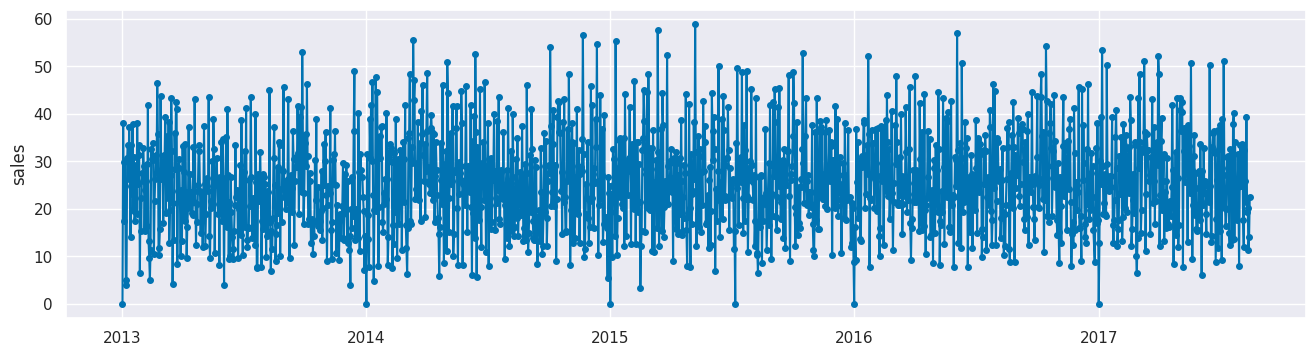

In [31]:
# Визуализация полученых данных при помощи встроенных утилит
sktime.utils.plotting.plot_series(df_SEAFOOD_sales);

В набор данных имеет как минимум 2 составляющие (быструю, с периодом неделя и медленную с периодом 1 год). Для наглядности вызу удалим быструю составляющую при помощи перегрупперовки данных.

In [32]:
y = df_SEAFOOD_sales.sales.asfreq('7d')
# y.index = pd.PeriodIndex(y.index) # pd.to_datetime(y.index)
y.head()

,sales
2013-01-01,0.000010
2013-01-08,30.767000
2013-01-15,23.085000
2013-01-22,18.955000
2013-01-29,15.414001


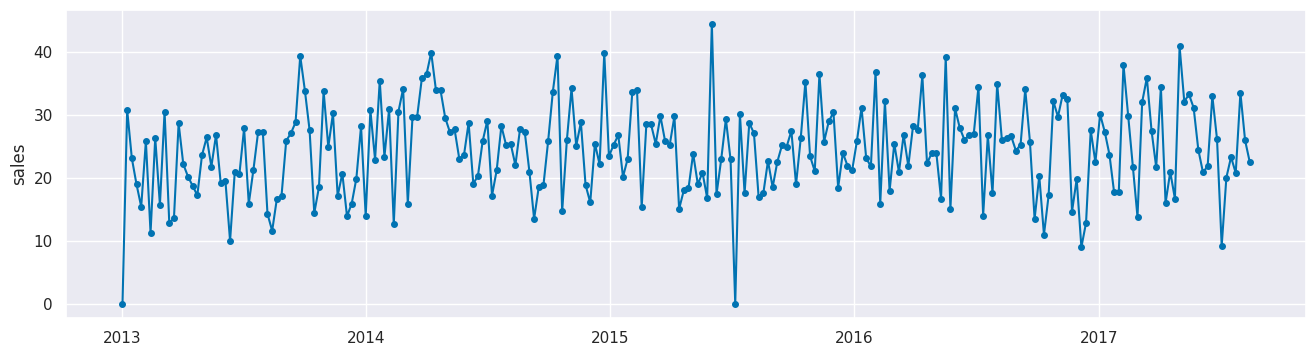

In [33]:
# Визуализация полученых данных при помощи встроенных утилит
sktime.utils.plotting.plot_series(y);

На графике сезонность прослеживается очень слабо, скорее можно сказать об ее отсутсвии. В 2013 году прослеживается тренд на увеличение продаж, 2014-2015 стабилизация, 2016 спад, 2017 снова стабилизация. Похоже, что ряд нестационарен. Это мы проверим программным способом в дальнейшем анализе.

Проанализируем быструю составляющую на примере данных за 2016 год.

In [34]:
# Фильтруем данные за 2016 год
df_SEAFOOD_sales_2016 = df_SEAFOOD_sales[df_SEAFOOD_sales.index.year == 2016]

df_SEAFOOD_sales_2016.head(5)

,sales
2016-01-01,0.00001
2016-01-02,16.20200
2016-01-03,9.19300
2016-01-04,36.77300
2016-01-05,25.75700


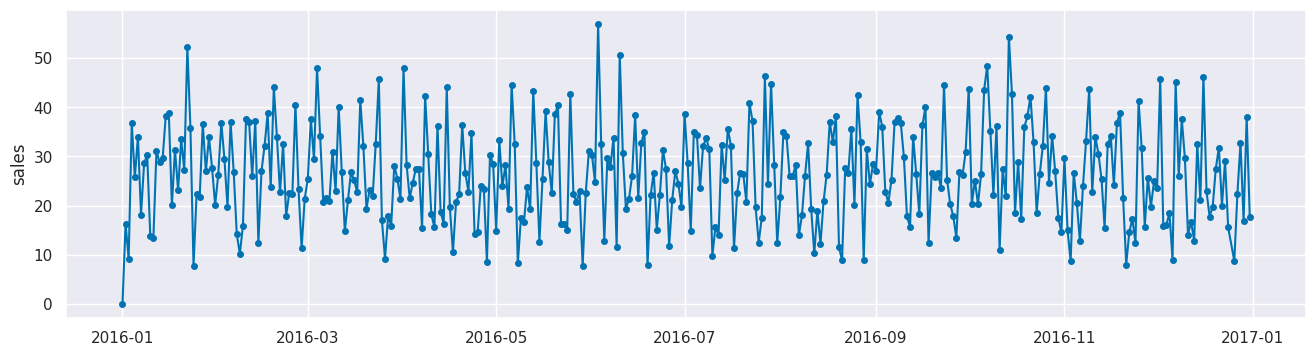

In [35]:
# Визуализация данных за 2016 год
sktime.utils.plotting.plot_series(df_SEAFOOD_sales_2016);

Наличие сезонности трудно определить визуально. Тренд также не прослеживается. Ряд, скорее всего, является стационарным.

# Предсказание временных рядов



Для разделения данных на обучающую и тестовую выборки воспользуемся функцией temporal_train_test_split, которя позволяет адаптировать разделение данных не разрушая временные зависимости в данных.

In [36]:
df_SEAFOOD_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   1684 non-null   float64
dtypes: float64(1)
memory usage: 90.9 KB


Проверка выборок после разделения данных: Тренировочная: 1461, Тестовая: 223


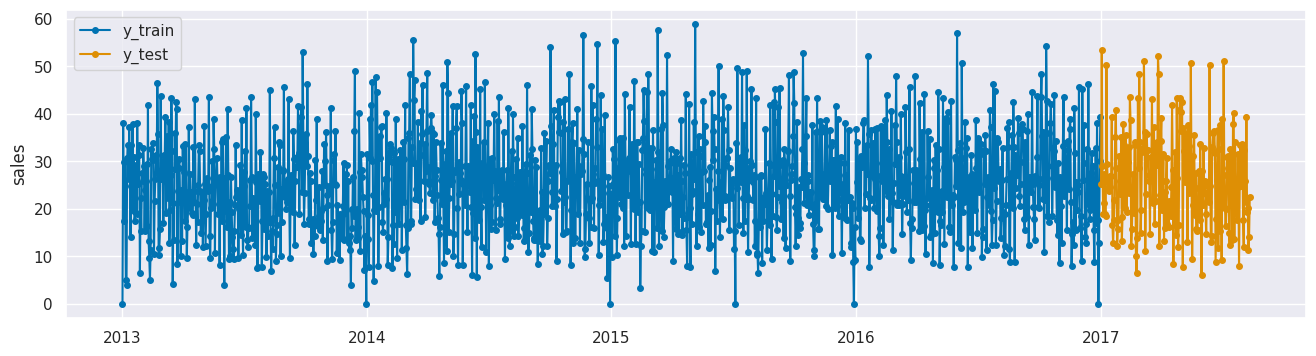

In [37]:
from pandas.tseries.offsets import Day  # Импорт Day

# Получение Series из Dataframe
y = df_SEAFOOD_sales['sales']
# print(y.index)

# Установка индекса с частотой
y.index = pd.date_range(start='2013-01-01', periods=len(y), freq=Day())

TEST_SIZE = int(0.3*y.size)

# y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)
# Выделение y_train и y_test
y_train = y['2013-01-01':'2016-12-31']
y_test = y['2017-01-01':]

print(f'Проверка выборок после разделения данных: Тренировочная: {y_train.shape[0]}, Тестовая: {y_test.shape[0]}')

sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);

Помимо разделения данных на тренировочные и тестовые, предсказание в `sktime` может потребовать т.н. `forecasting horizon` - то есть непосредственного указания числа предсказываемых значений. Такой горизонт предсказания можно задавать по разному, при помощи массива или объекта класса `ForecastingHorizon`. Последний способ предоставляет более развитый инструментарий.

In [38]:
# ГОРИЗОНТ
#fh = np.arange(y_test.size) + 1
fh = ForecastingHorizon(y_test.index, is_relative=False)

## Метод с предварительной декомпозицией временного ряда

Другим методом оценки данных с вилянием сезонности и тренда является использование предварительной декомпозиции временного ряда. Одним из наиболее простых методов декомпозиции явялется разделение на тренд, сезонность и остаток. Давайте посмотрим на то, как будут выглядеть результаты такого разложения.

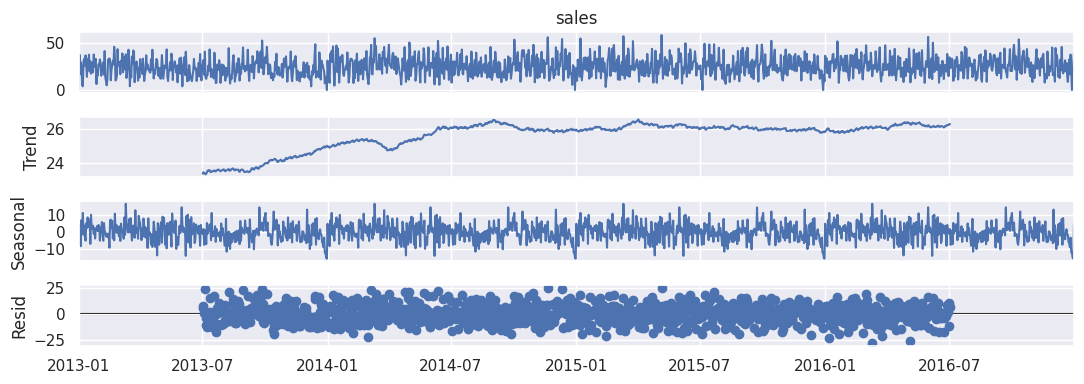

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y_train, model='additive', period = 365)  # период
result.plot();

В рамках пакета SKTime разложение можно выполнить при помощи объектов класса Deseasonalizer и Detrender.

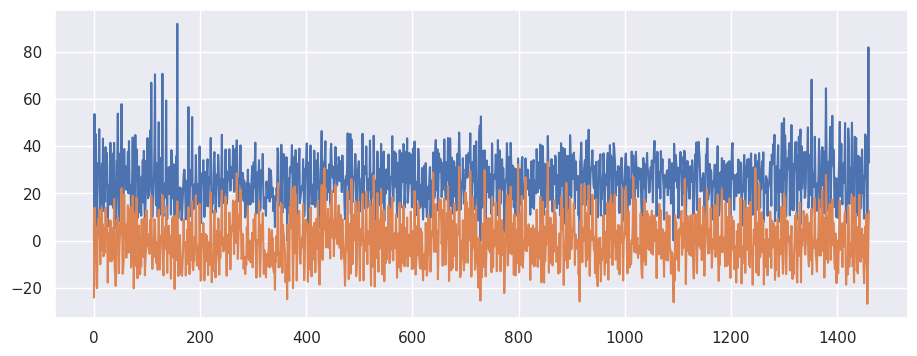

In [40]:
deseason = Deseasonalizer(model="multiplicative", sp=365)   # период
detrend  = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
plt.plot(deseason.fit_transform(y_train.values))
plt.plot(detrend.fit_transform(y_train.values))

Посмотрим на работу наиболее простого экспоненциального сглаживания с использованием разложения. Для этого будем использовать контейнер TransformedTargetForecaster - который явлется некоторым аналогом пайплайна.

Средняя абсолютная процентная ошибка (sMAPE) = 0.402
RMSE: 12.942


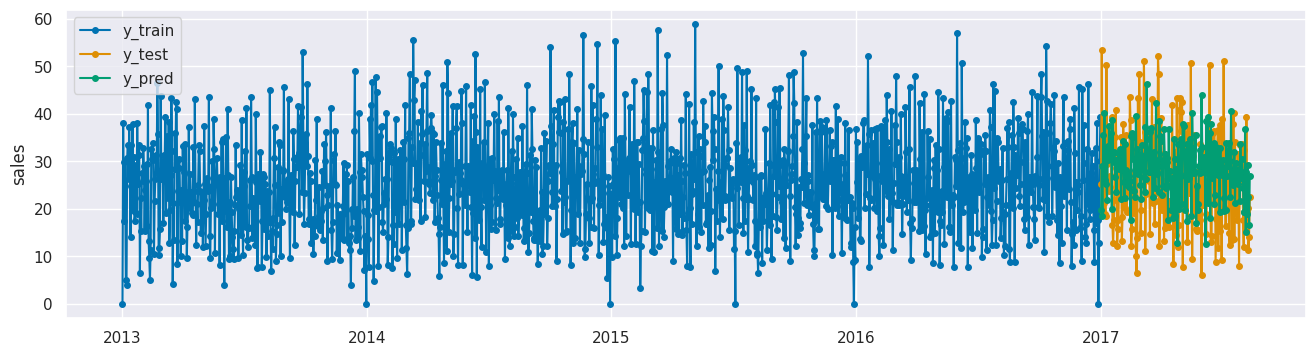

In [41]:
SEASON = 365

fh = ForecastingHorizon(y_test.index, is_relative=False)

# объект предсказатель
ses         = ExponentialSmoothing()

# пайплайн
forecaster = TransformedTargetForecaster(
                steps=[
                ("deseasonalize", Deseasonalizer(model="multiplicative", sp=SEASON)),
                ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
                ("forecaster", ses)
                ])
forecaster.fit(y_train)

# Предсказание
y_pred = forecaster.predict(fh)

# Результаты
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# Вычисляем метрики
print(f'Средняя абсолютная процентная ошибка (sMAPE) = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE: {rmse(y_pred.values, y_test.values):.3f}')

## Использование пакета Scikit-learn для предсказаний

### Рассмотрим регрессию ближайших соседей.

Средняя абсолютная процентная ошибка (sMAPE) = 0.363
Среднеквадратическая ошибка (RMSE) = 10.801


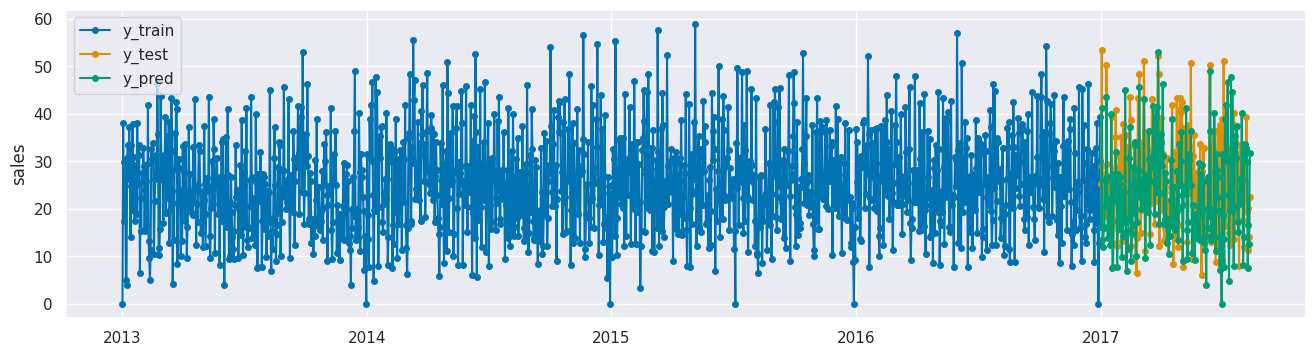

In [47]:
from sklearn.neighbors import KNeighborsRegressor

REGRESSION_WINDOW = 15

regressor  = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print('='*80)
print(f'Средняя абсолютная процентная ошибка (sMAPE) = {smape(y_pred.values, y_test.values):.3f}')
print(f'Среднеквадратическая ошибка (RMSE) = {rmse(y_pred.values, y_test.values):.3f}')

### Предсказание продаж на месяц вперед с помощью модели Регрессии ближайших соседей

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

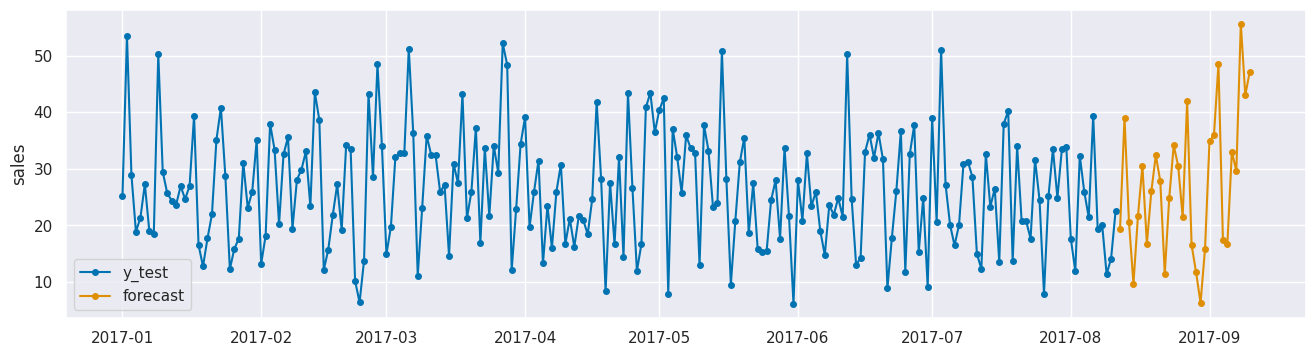

In [50]:
# Настройка будущих дат для предсказания
last_date = y_test.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)  # 30 дней вперед

# Предсказание на основе имеющихся данных
forecast = forecaster.predict(future_dates)

plot_series(y_test, forecast, labels=["y_test", "forecast"])

## Современный метод регресии Prophet представленный в пакете SKTime

Prophet - метод предсказания временных рядов на основе т.н. обобщенной регресии для модели бизнесс процессов, которая включает тренд с точками перегиба и насыщением, несколько компонент сезонности и редкие но регулярные события (типа выходных дней).

In [45]:
# Cоздаем новый DataFrame с праздничными днями в нужном формате
holidays = pd.DataFrame({
    'ds': holiday_data.index,  # Используем индекс как даты
    'holiday': holiday_data['description']  # Используем столбец 'description' как названия праздников
})

# Выводим новый DataFrame
print(holidays)

                   ds                        holiday
date                                                
2012-03-02 2012-03-02             Fundacion de Manta
2012-04-01 2012-04-01  Provincializacion de Cotopaxi
2012-04-12 2012-04-12            Fundacion de Cuenca
2012-04-14 2012-04-14      Cantonizacion de Libertad
2012-04-21 2012-04-21      Cantonizacion de Riobamba
...               ...                            ...
2017-12-22 2017-12-22                      Navidad-3
2017-12-23 2017-12-23                      Navidad-2
2017-12-24 2017-12-24                      Navidad-1
2017-12-25 2017-12-25                        Navidad
2017-12-26 2017-12-26                      Navidad+1

[350 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp76rmbf4c/ordwav8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp76rmbf4c/qbrqhf0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84661', 'data', 'file=/tmp/tmp76rmbf4c/ordwav8k.json', 'init=/tmp/tmp76rmbf4c/qbrqhf0y.json', 'output', 'file=/tmp/tmp76rmbf4c/prophet_modelm4bg5e3g/prophet_model-20241025194708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Средняя абсолютная процентная ошибка (sMAPE) = 0.354
Среднеквадратическая ошибка (RMSE) = 11.253


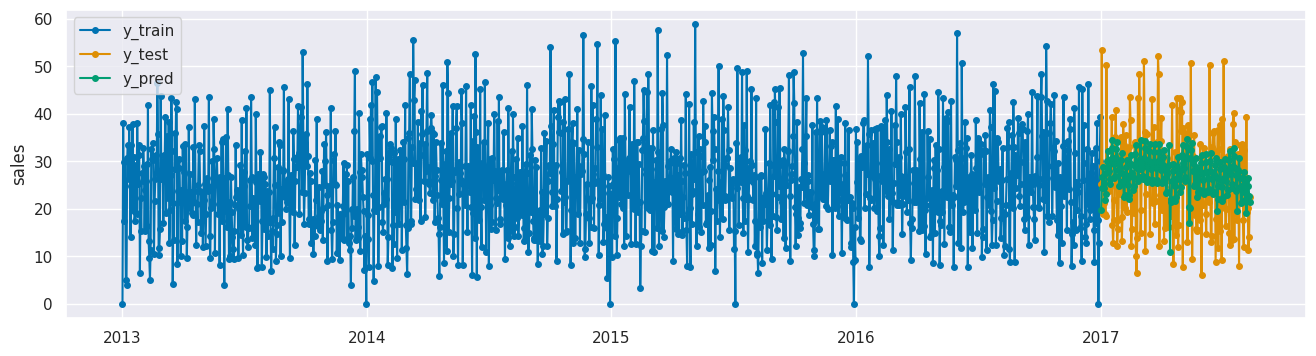

In [60]:
forecaster = Prophet(
                    freq='D',
                    seasonality_mode='additive',
                    n_changepoints=int(len(y_train) / 8),
                    holidays=holidays,
                    yearly_seasonality=True,
                    weekly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print('='*80)
print(f'Средняя абсолютная процентная ошибка (sMAPE) = {smape(y_pred.values, y_test.values):.3f}')
print(f'Среднеквадратическая ошибка (RMSE) = {rmse(y_pred.values, y_test.values):.3f}')

In [48]:
y_test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 223 entries, 2017-01-01 to 2017-08-11
Freq: D
Series name: sales
Non-Null Count  Dtype  
--------------  -----  
223 non-null    float64
dtypes: float64(1)
memory usage: 3.5 KB


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

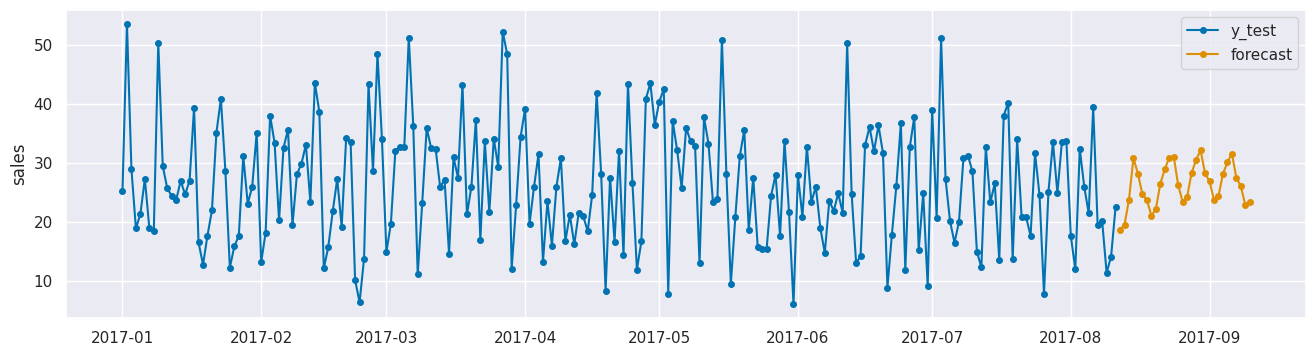

In [56]:
# Настройка будущих дат для предсказания
last_date = y_test.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)  # 30 дней вперед

# Предсказание на основе имеющихся данных
forecast = forecaster.predict(future_dates)

# Визуализируем график с предсказаниями
plot_series(y_test, forecast, labels=["y_test", "forecast"])

# Модели авторегрессии-скользящего среднего

# Анализ полученного однопеременного ряда

Для модели `AutoregRessive Integrated Moving Average` (`ARIMA`) существует три  параметра (порядка) (`p, d, q`):
* `p` - **авторегрессивная часть модели**. Этот параметр позволяет учесть влияние прошлых значений на текущее для модели. Прошлые значения здесь называются запаздывающими наблюдениями (также известными как «запаздывание» или «лаг»). Интуитивно это похоже на утверждение, что завтра, вероятно, будет тепло, если в последние 3 дня было тепло. Другими словами, здесь мы можем сказать, что текущее значение температуры зависит от последних трех значений.

* `d` – **интегрирование модели**. Этот параметр включает в себя степень различия лагов (то есть количество прошлых временных точек, которые нужно вычесть из текущего значения), чтобы сделать временной ряд стационарным (чтобы исключить часть тренда). Интуитивно это было бы похоже на утверждение о том, что, вероятно, будет одно и то же повышение температуры каждый день (или одно и то же ускорение для второй производной и т.д.).

* `q` - **скользящая средняя часть модели**. Этот параметр позволяет представить остаточную часть (шум, ошибку) модели как линейную комбинацию остаточных значений, наблюдаемых в предыдущие моменты времени.

Если в модели видно достаточно сильное влияние сезонной составляющей, то следует перейти к модели `ARIMA` с сезонными эффектами (`Seasonal ARIMA - SARIMA`).  Как правило такая модель обозначается как
$$SARIMA (p, d, q) (P, D, Q) s.$$
Где
* (`p, d, q`) -  несезонные параметрами, описанными выше;
* (`P, D, Q`) - сезеонные порядки, которые следуют тому же порядку определений как и описанныевыше, но применяются к сезонной составляющей временного ряда;
* `s` - это периодичность временного ряда (например, 4 для квартальных периодов, 12 для годовых периодов и т.д.).

Рассмотрим процедуру ручного выбора порядков модели. Как правило, начинать следует с дифференцирования для достижения стационарности. Как правило, это `1-3` порядок, реже - больше.

Правильный порядок дифференцирования (`d, D`) это порядок разности, который делает временной ряд шумоподобным
т.е. значения колеблется около четко определенного среднего и имеют почти постоянный разброс значений. При этом рекомендуется использовать сезонную производную только в случае сильного сезонного влияния.

## Импорт необходимых библиотек и модулей

In [61]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [62]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
#smape = MeanAbsolutePercentageError(symmetric = True)
#rmse  = MeanSquaredError(square_root=True)
#r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

## Проверка временного ряда на стационарность

Для проверки стационарности после дифференцирования можно ипользовать несколько методов, в том числе:
* **Скользящая статистика**: построение скользящего среднего и скользящего стандартного отклонения. Идея этого метода в том, что временные ряды являются стационарными, если они остаются неизменными во времени. Скользящая статистика визуально показывает стационарность среднего значения.
* **Статистические тесты, в т.ч. Расширенный тест Дики-Фуллера**: временной ряд считается стационарным, если
значение `p-value` низкое (в соответствии с нулевой гипотезой), а критические значения с доверительными интервалами `1%, 5%, 10%` максимально близки к табличному значению параметра `ADF` (такой параметр принято назвывать `статистика ADF`). Если тест `ADF` показывает, что статистика `ADF` далека от критических значений, а значение `p-value` превышает пороговое значение (например (0,05), то ряд  является нестационарным. В обратном случае ряд следует признать стационарным.

Расширенный тест Дики-Фуллера для проверки стационарности временного ряда.

In [63]:
P_THRESHOLD = 0.05
def check_ADF(y, p_threshold = P_THRESHOLD):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.8f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))
    print(f'Result: The series is {"not " if p_value > p_threshold else ""}stationary')
    return result

check_ADF(y_train, p_threshold = P_THRESHOLD);

ADF Statistic: -6.5511
p-value: 0.00000001
Critical Values:
	1%: -3.4349, 
	5%: -2.8636, 
	10%: -2.5678, 
Result: The series is stationary


Наиболее распространенной причиной нарушения стационарности является тенденция к среднему значению, которое может быть обусловлено либо наличием единого корня, либо детерминированного тренда.

Значение p-value выше уровня значимости, следовательно у нас нет оснований отклонить нулевую гипотезу о нестационарности ряда.
В нашем случае значение p-value значительно ниже уровня значимости 0,05, следовательно мы с достаточной степенью уверенности можем отклонить нулевую гипотезу и принять альтернативную о том, что ряд является не стационарным.

Для применения дальнейших методов необходимо преобразовать нестационарный ряд к стационарному. С этим может помочь Дифференциальный метод (Differencing).

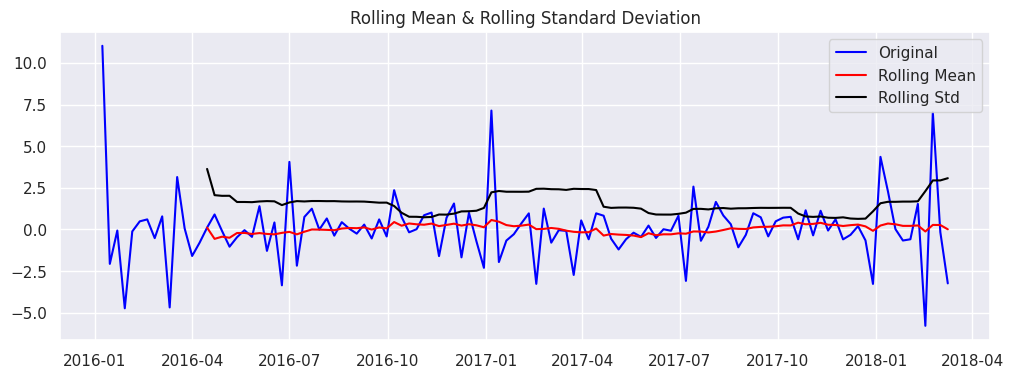

ADF Statistic: -11.3303
p-value: 0.00000000
Critical Values:
	1%: -3.4901, 
	5%: -2.8877, 
	10%: -2.5807, 
Result: The series is stationary


In [ ]:
y_diff = y_train[:].diff(1).dropna()

rolling_mean = y_diff.rolling(window = 15).mean()
rolling_std  = y_diff.rolling(window = 15).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_diff,       color = 'blue',  label = 'Original')
plt.plot(rolling_mean, color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,  color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

result = check_ADF(y_diff)

Нам повезло: после первого пименения дифференциальной функции ряд стал стационарным. Так случается не всегда. В таких случаях производят данную операцию последовательно до приведения рада к стационарному. Однако избыточная дифференциация может привести к переобучению модели, поскольку она может акцентироваться на шуме, а не на значимых паттернах. Это создаст риск низкой обобщающей способности модели на новых данных.

Мы можем заключить что предварительной оценкой порядков дифференциации (интегрирования) являются: $d=1; D=1; s=52$.

## Рассмотрим графики ACF и PACF

При помощи графиков выберем оптимальные параметры авторегрессии-скользящего среднего.

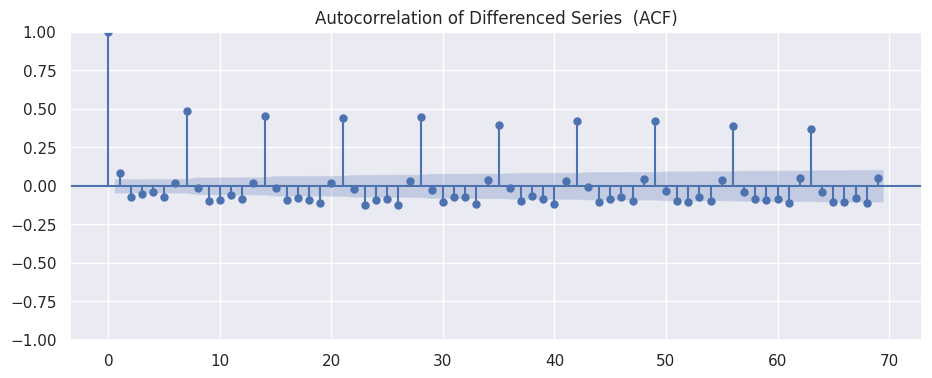

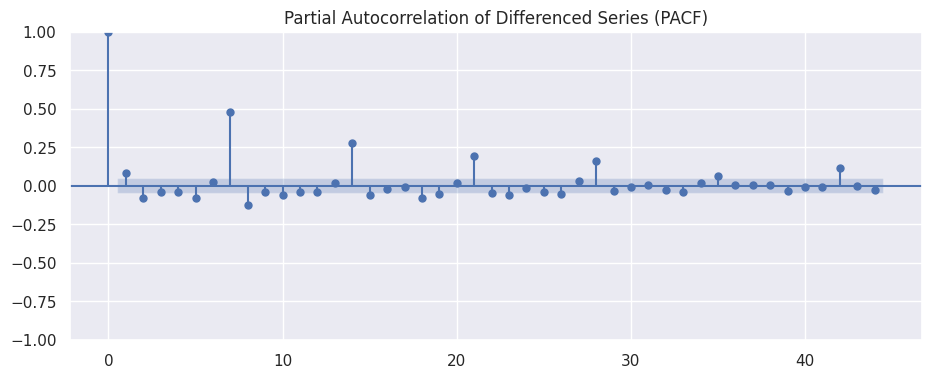

In [64]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Usual Differencing
plot_acf(y, title='Autocorrelation of Differenced Series  (ACF)', lags=np.arange(70) );plt.show()
# Usual Differencing
plot_pacf(y, title='Partial Autocorrelation of Differenced Series (PACF)', method='ywm', lags=np.arange(45));plt.show()

Из графиков выше следует следующий выбор параметров.
* Порядок q = 15 модели `MA`  (максимальный лаг, после которого значения ACF становятся незначительными или близкими к нулю);
* Порядок p = 5 модели  `AR`  (6 лаг `PACF` ниже нуля);
* К ряду один раз применялась дифференциальная функция, поэтому d = 1;


## Проверим модель SARMA

In [65]:
# Для быстрой проверки обучения возьмем данные только за 2016 год
y_train_2016 = y_train[y_train.index.year == 2016]

In [66]:
forecaster = SARIMAX(order=(1, 0, 1), seasonal_order=(0, 1, 0, 365))
forecaster.fit(y_train_2016)
print(forecaster.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                  366
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 365)   Log Likelihood               -1349.774
Date:                             Fri, 25 Oct 2024   AIC                           2711.549
Time:                                     20:30:52   BIC                           2734.964
Sample:                                 01-01-2016   HQIC                          2720.853
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     29.9555   3.62e+04      0.001      0.999   -7.09e+04    7.09e+04
ar.L1         -0.7677      

Выведенные результаты аппроксимации модели раскрывает достаточно много информации. В первой таблице представлена общая информация, включая критерии качества (`AIC, BIC` и `HQIC`). Таблица
посередине - это таблица коэффициентов, где значения столбца `coef` - это веса
соответствующих слогаемых. Значение `sigma2` – это `RSS` (средне квадратическая) ошибка модели. В последней
таблице представлены результаты различных статистических тестов для полученных остатков.

Помимо табличного представления, мы можем проводить диагностику остатков графическим способом. Напомним, что остатки в данном контексте означают разность модели, аппроксимированной при помощи `SARIMA` и тренеровочных данных.
Отметим, что данный способ не является стандартным методом класса `SARIMAX`, однако присуствует в нем.

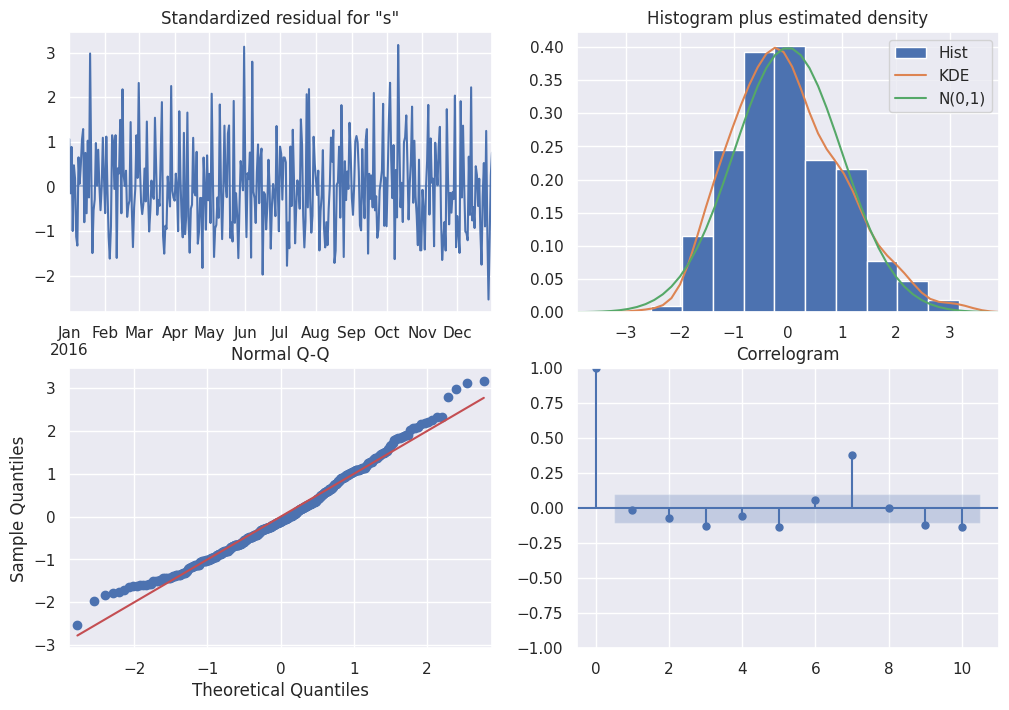

In [67]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

На графиках выше мы видим:
* *верхний левый  график*: остаточные ошибки колеблются около нулевого среднего, однако имеют несколько неравномерную дисперсию, возможно модель недодифференцирована.
* *верхний правый график*: остаток имеет распределние, похожее на нормальное распределение.
* *нижний левый график*: график `Q-Q` показывает отклонения от нормального распределения.
* *нижний правый график*: автокорреляционная функция не показывает значительных (статистически значемых) отличий от нормального распределния.

Проведенный анализ показывает, что модель достаточна хороша, но можно попытаться её улучшить. При ручном поборе порядка модели следует отдавать предпочтения моделям с наименьшим значением критериев качества и с наименьшей ошибкой `RSS`.

В качестве первого предположения мы можем попытаться увеличить порядок дифференцирования модели.  После можно попробовать несколько значений разных порядков.

Теперь давайте попробуем визуализировать предсказания нашей модели.

Средняя абсолютная процентная ошибка (sMAPE) = 0.392
Среднеквадратическая ошибка (RMSE) = 12.806


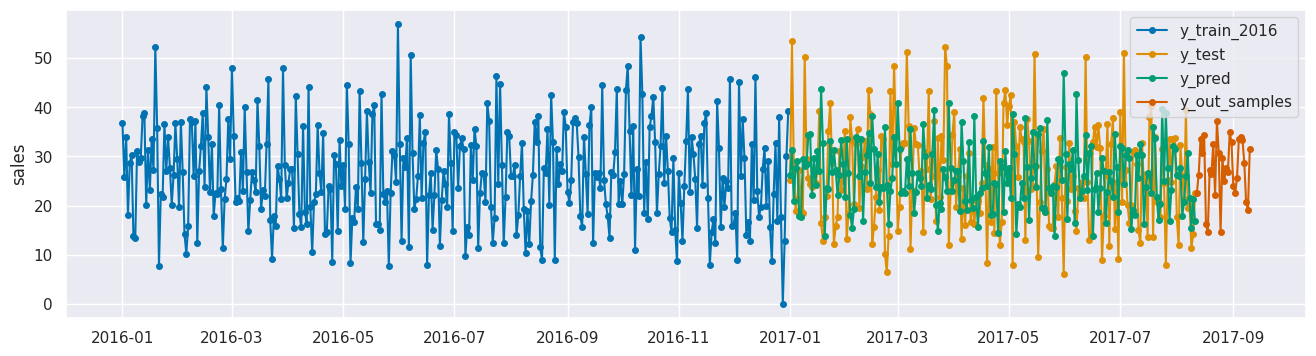

In [83]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

fhout = ForecastingHorizon(future_dates, is_relative=False)
y_out = forecaster.predict(fhout)
plot_series(y_train_2016, y_test, y_pred, y_out, labels=["y_train_2016", "y_test", "y_pred", "y_out_samples"])

print('='*80)
print(f'Средняя абсолютная процентная ошибка (sMAPE) = {smape(y_pred.values, y_test.values):.3f}')
print(f'Среднеквадратическая ошибка (RMSE) = {rmse(y_pred.values, y_test.values):.3f}')

Сравнение точности классических методов классификации и методов глубокого обучения в контексте временных рядов или задач классификации может зависеть от множества факторов, включая характер данных, сложность задач и количество доступной информации для обучения модели.

##Методы глубокого обучения:##
1. MUSE - 0.988
2. TimeSeriesForestClassifier - 0.986
3. RandomIntervalSpectralEnsemble - 0.991
4. SupervisedTimeSeriesForest - 0.982

##Классические методы классификации:##
1. RandomForestClassifier - 0.963
2. KNeighborsClassifier - 0.966
3. KNeighborsTimeSeriesClassifier - 0.977
4. ShapeletTransformClassifier - 0.984
5. IndividualBOSS - 0.933
6. IndividualTDE - 0.933
7. Наименьшая ошибки моделей ARIMA составила 4,9%.
8. У модели Prothet ошибка составила 4,8%.

#Результаты и аналитика#
##Глубокое обучение:##


Наивысшую точность показывает метод RandomIntervalSpectralEnsemble с результатом 0.991, что делает его одним из самых эффективных решений.


Также высокие результаты у MUSE и TimeSeriesForestClassifier с точностями 0.988 и 0.986 соответственно, что говорит о том, что они способны эффективно справляться с различными задачами классификации временных рядов.


##Классические методы:##


RandomForestClassifier и KNeighborsClassifier показывают относительно высокие результаты, однако, они уступают по качеству методам глубокого обучения и специальным ансамблевым методам.
Несмотря на то, что ShapeletTransformClassifier показывает довольно высокий результат (0.984), он все же ниже, чем некоторые модели глубокого обучения.

Модели ARIMA могут выдать результат с достаточно невысокой ошибкой 5%, однако эта ошибки выше, чем при использовании других продвинутых методов.

##Рекомендации по выбору метода классификации:##

Если объем данных достаточный для обучения сложных моделей и ресурсы, чтобы запускать их, я бы рекомендовал использовать RandomIntervalSpectralEnsemble или MUSE. Эти методы показывают наивысшую точность и могут лучше учесть сложные паттерны в данных.

В случае ограничений по вычислительным ресурсам или меньшего объема данных можно рассмотреть использование ShapeletTransformClassifier или KNeighborsTimeSeriesClassifier, так как они показывают хорошие результаты без необходимости в обработке больших объемов данных, что упрощает процесс их обучения.


Также стоит обратить внимание на методы, использующие ансамбли (например, SupervisedTimeSeriesForest), поскольку они могут объединять силу нескольких моделей, повышая общую точность классификации.


#Заключение#
В зависимости от целей, характеристик данных и наличия ресурсов предлагается выбирать среди указанных методов, ориентируясь на их производительность и доступность. Исторически, методы глубокого обучения показывают лучшие результаты, но классические алгоритмы часто могут быть более легкими в реализации и интерпретации.